#DATA QUALITY ASSESSMENT FOR CRIME DATA

vrk3359@nyu.edu


ss17454@nyu.edu


ag9544@nyu.edu

# Install Required dependencies

---



---







In [ ]:
!pip install pyspellchecker
!pip install fuzzywuzzy
!pip install python-Levenshtein
!pip install fpdf
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 42.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40703 sha256=892755f20d4ed8aabf4b23b3e64c87953cafc5a711bf74fad87cab91b865f32f
  Stored in directory: /root/.cache/pip/wheels/f9/95/ba/f418094659025eb9611f17cbcaf2334236bf39a0c3453ea455
Successfully built fpdf
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=8e02721c3dd4183cf117ad528e7367c5f1696b0f3220797a86b19f2c94df9103
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


# Import required libraries

---


---





In [ ]:
import pandas as pd
from dateutil import parser
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
import matplotlib.pyplot as plt
from dateutil import parser
import re
from collections import Counter
import pandas as pd
from collections import defaultdict
from spellchecker import SpellChecker
from fuzzywuzzy import process

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, NumericType
from pyspark.sql.functions import col, lit
from pyspark.sql.functions import lower, trim, sum as _sum
from pyspark.sql.functions import col, isnan, when, sum as _sum
from pyspark.sql.functions import col, lower, trim, when, sum as _sum
from pyspark.sql.functions import col, length
from pyspark.sql.functions import col, isnan, isnull
from pyspark.sql import Row
from pyspark.sql.functions import col, udf, sum as _sum
from pyspark.sql.types import IntegerType
import re

DEPENDECIES ON THE CODE


---



In [ ]:
keywords = ['X_COORD', 'Y_COORD', 'Latitude', 'Longitude','AGE']
range_constraints = {
    'x_coord': (900000, 1060000),  # Example range for NYC projected coordinates
    'y_coord': (120000, 280000),   # Example range for NYC projected coordinates
    'latitude': (-90, 90),         # Geographical coordinate range
    'longitude': (-180, 180),       # Geographical coordinate range
    "AGE": (1,120)
}
date_formats = [
    '%Y-%m-%d', '%Y%m%d', '%Y-%m-%dT%H:%M:%S',
    '%m/%d/%Y', '%m-%d-%Y', '%m/%d/%y',
    '%d/%m/%Y', '%d-%m-%Y', '%d/%m/%y',
    '%d %b %Y', '%B %d, %Y', '%Y/%m/%d',
    '%y-%m-%d', '%d-%m-%y', '%m/%d/%Y %H:%M',
    '%Y-%m-%d %H:%M:%S', '%d/%m/%Y %H:%M:%S',
    '%Y-%m-%dT%H:%M:%SZ', '%Y-%m-%dT%H:%M:%S+00:00',
    '%Y-W%W', '%Y-W%W-%w', '%Y-%j'
]

INTITALIZE SPARK SESSION AND CREATE A DATAFRAME USING SPARK AND PANDAS

In [ ]:
# Initialize a Spark session
spark = SparkSession.builder.appName("load_dataset").getOrCreate()
# Path to your dataset file
#file_path = "/content/NYPD_Arrest_Data__Year_to_Date__20231120.csv"  # Replace with your file path
file_path = "/content/NYPD_Complaint_Data_Current__Year_To_Date__20231208.csv"
# Load the dataset into a DataFrame
df = spark.read.csv(file_path, header=True, inferSchema=True)
df_pandas = pd.read_csv(file_path)
df.show()

<ipython-input-9-0e4031b06c19>:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_pandas = pd.read_csv(file_path)


+-----------+-----------+-------------+------------+-------------------+------------+------------+----------------+----------+-----------+-----------------+-------------------+-----+-----------+-----------------+--------------------+--------+--------------------+-----+--------------------+--------------------+----------+------------+--------------+--------------------+--------+----------------+-------------+--------------------+-------+----------+----------+-----------------+------------------+--------------------+------------------------+
| CMPLNT_NUM|ADDR_PCT_CD|      BORO_NM|CMPLNT_FR_DT|       CMPLNT_FR_TM|CMPLNT_TO_DT|CMPLNT_TO_TM|CRM_ATPT_CPTD_CD|HADEVELOPT|HOUSING_PSA|JURISDICTION_CODE|         JURIS_DESC|KY_CD| LAW_CAT_CD|LOC_OF_OCCUR_DESC|           OFNS_DESC|PARKS_NM|         PATROL_BORO|PD_CD|             PD_DESC|       PREM_TYP_DESC|    RPT_DT|STATION_NAME|SUSP_AGE_GROUP|           SUSP_RACE|SUSP_SEX|TRANSIT_DISTRICT|VIC_AGE_GROUP|            VIC_RACE|VIC_SEX|X_COORD_CD|Y_C

# Different Pyspark SQL techniques used to identify quality issues in any given dataset

---



---



PRELIMINARY ANALYSIS ON ALL COLUMNS TO CHECK FOR NUMERIC,APLHANUMERIC AND CHARACTER VALUES IN THE COLUMN

---



In [ ]:
# UDFs for checking value types
def is_numeric(value):
    value = str(value) if value is not None else ''
    return 1 if re.match(r'^\d+$', value) else 0

def is_alphanumeric(value):
    value = str(value) if value is not None else ''
    return 1 if re.match(r'^[a-zA-Z0-9]+$', value) and not re.match(r'^\d+$', value) else 0

def is_character(value):
    value = str(value) if value is not None else ''
    return 1 if not re.match(r'^[a-zA-Z0-9]+$', value) else 0

# Registering UDFs
is_numeric_udf = udf(is_numeric, IntegerType())
is_alphanumeric_udf = udf(is_alphanumeric, IntegerType())
is_character_udf = udf(is_character, IntegerType())

# Function to apply UDFs and count value types
def count_value_types(spark_df, column_name):
    result_df = spark_df.withColumn("numeric_count", is_numeric_udf(col(column_name))) \
                        .withColumn("alphanumeric_count", is_alphanumeric_udf(col(column_name))) \
                        .withColumn("character_count", is_character_udf(col(column_name))) \
                        .select(_sum("numeric_count").alias("total_numeric_count"),
                                _sum("alphanumeric_count").alias("total_alphanumeric_count"),
                                _sum("character_count").alias("total_character_count"))

    return result_df
results_list = []
for column in df.columns:
    result_row = count_value_types(df, column).first().asDict()
    result_row['column'] = column
    results_list.append(result_row)

# Create a new DataFrame from the collected results
results_df = spark.createDataFrame([Row(**row) for row in results_list])
# Show the results in tabular form
results_df.show(truncate=False)
# Shows Statistics Summary of dataset
summary_statistics = df_pandas.describe()
print(summary_statistics)

+-------------------+------------------------+---------------------+-----------------+
|total_numeric_count|total_alphanumeric_count|total_character_count|column           |
+-------------------+------------------------+---------------------+-----------------+
|415006             |304                     |0                    |CMPLNT_NUM       |
|415258             |0                       |52                   |ADDR_PCT_CD      |
|0                  |396188                  |19122                |BORO_NM          |
|0                  |0                       |415310               |CMPLNT_FR_DT     |
|0                  |0                       |415310               |CMPLNT_FR_TM     |
|0                  |0                       |415310               |CMPLNT_TO_DT     |
|0                  |0                       |415310               |CMPLNT_TO_TM     |
|0                  |415310                  |0                    |CRM_ATPT_CPTD_CD |
|0                  |1044                  

NULL Values Detection, Duplicate Value Detection, Outlier Detection


In [ ]:
def calculate_null_counts(df):
    """
    Calculate the count of null values for each column in the DataFrame.

    Parameters:
    - df (DataFrame): PySpark DataFrame

    Returns:
    - null_counts (DataFrame): DataFrame containing null counts for each column
    """
    null_counts = df.agg(*[F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns])
    return null_counts
#duplicate data
def duplicate_data(spark, dataframe):
    # Drop duplicate rows and count them
    duplicate_count = dataframe.dropDuplicates().count()

    print("Count of duplicate rows:", duplicate_count)
    return duplicate_count

def count_outliers(spark, df, threshold=2.0):
    # Read the dataset
    #df = spark.read.csv(dataset_path, header=True, inferSchema=True)

    # Register the DataFrame as a temporary table
    df.createOrReplaceTempView("my_table")

    # Get the list of integer columns
    integer_columns = [col_name for col_name, col_type in df.dtypes if col_type == 'int']

    # Create a list to store the count of outliers for each integer column
    outlier_counts = []

    # Iterate over each integer column in the DataFrame
    for column in integer_columns:
        # Write a SQL query using a subquery to count the outliers for each integer column
        query = f"""
            SELECT COUNT(*) as outlier_count
            FROM (
                SELECT {column}, AVG({column}) OVER () as avg_col, STDDEV({column}) OVER () as stddev_col
                FROM my_table
            ) subquery
            WHERE ABS({column} - avg_col) > {threshold} * stddev_col
        """

        # Execute the SQL query and collect the result
        result = spark.sql(query).collect()[0]

        # Append the result to the outlier_counts list
        outlier_counts.append((column, result.outlier_count))

    # Display the counts of outliers for each integer column
    for column, count in outlier_counts:
        print(f"Column '{column}': {count} outliers")

Misspelling Detection


In [ ]:
def check_spelling(spark, dataframe):
    spell = SpellChecker()
    alphabet_characters = [chr(i) for i in range(ord('a'), ord('z') + 1)]
    spell.word_frequency.load_words(alphabet_characters)

    misspelling_indicator = []
    misspelling_counts = {}

    for column in dataframe.columns:
        if dataframe.schema[column].dataType != StringType():  # Skip non-string columns
           # print(f"{column} : 0 (as it is not a string column)")
            continue

        # Skip columns with date values
        if any(dataframe.rdd.map(lambda x: is_date(x[column])).collect()):
           # print(f"Skipping column '{column}' as it contains date values.")
            continue

        #print(f"Checking misspellings in column '{column}':")

        # Convert to lowercase and split strings by whitespace
        words = dataframe.rdd.flatMap(lambda x: x[column].lower().split() if x[column] is not None else []).collect()

        # Find misspelled words
        misspelled = spell.unknown(words)

        if misspelled:
            count = len(misspelled)
            print(f"{column} : {len(misspelled)}")
            misspelling_indicator.append(F.lit(True))
            misspelling_counts[column] = count
        else:
            print(f"No misspellings found in {column}.")
            misspelling_indicator.append(F.lit(False))
            misspelling_counts[column] = 0

    # Combine individual column misspelling indicators into a row-wise indicator
    misspelling_rowwise = F.array(*misspelling_indicator)
    dataframe = dataframe.withColumn('Misspelling', F.when(F.size(misspelling_rowwise) > 0, F.array_contains(misspelling_rowwise, True)).otherwise(F.lit(False)))

    columns = list(misspelling_counts.keys())
    counts = list(misspelling_counts.values())

    return dataframe

#check_spelling(spark, df)


INVALID VALUES CODE BY PYSPARK

In [ ]:

#to segregate the columns into numerical and string columns
def segregate_columns(spark_df):
    numerical_cols = []
    string_cols = []

    for field in spark_df.schema.fields:
        # Check if the column's data type is numeric
        if isinstance(field.dataType, NumericType):
            numerical_cols.append(field.name)
        # Check if the column's data type is string
        elif isinstance(field.dataType, StringType):
            string_cols.append(field.name)

    return numerical_cols, string_cols

#to find the column names with particular search key word
def fuzzy_match_columns(spark_df, search_keys):
    matched_columns = {}
    column_names = spark_df.columns

    for key in search_keys:
        # Use fuzzy matching to find the best match for each search key
        best_match, score = process.extractOne(key, column_names)
        # Consider it a match if the score is above a certain threshold, e.g., 80
        if score > 80:
            matched_columns[key] = best_match
        else:
            matched_columns[key] = None

    return matched_columns

#to check for latitude,longitude,x-coord,y_coord  out of range values ie. invalid values for these columns
def count_invalid_values_per_geocolumn(spark_df, range_constraints, matched_columns):
    invalid_counts = {}
    for key, column_name in matched_columns.items():
        if column_name in spark_df.columns:
            min_value, max_value = range_constraints[key]
            print(f"Checking column: {column_name}, Min: {min_value}, Max: {max_value}")

            # Count invalid entries for each column
            invalid_count = spark_df.filter(~col(column_name).between(min_value, max_value)).count()
            invalid_counts[column_name] = invalid_count
        else:
            invalid_counts[column_name] = 'Column not found'

    return invalid_counts


#to check for invalid values in string columns
def count_invalid_string_values(spark_df, string_columns):
    invalid_values = {'na', 'n/a', 'none', 'not available', 'unknown', 'missing'}
    invalid_value_counts = {}

    for column in string_columns:
        if column in spark_df.columns:
            # Identify rows with invalid string values
            invalid_rows = spark_df.withColumn(
                'is_invalid',
                lower(trim(col(column))).isin(invalid_values)
            )

            # Count the invalid entries
            invalid_count = invalid_rows.agg(_sum(col('is_invalid').cast('int')).alias('invalid_count')).collect()[0]['invalid_count']
            invalid_value_counts[column] = invalid_count
        else:
            invalid_value_counts[column] = 'Column not found'

    return invalid_value_counts


#invalid values in numeric column
def count_garbage_values_numeric(spark_df, numeric_columns):
    garbage_value_counts = {}

    for column in numeric_columns:
        if column in spark_df.columns:
            # Count entries that are NaN or extreme values
            garbage_count = spark_df.withColumn(
                'is_garbage',
                isnan(col(column)) | (col(column).cast('double') > 1e12) | (col(column).cast('double') < -1e12)
            ).agg(_sum(col('is_garbage').cast('int')).alias('garbage_count')).collect()[0]['garbage_count']

            garbage_value_counts[column] = garbage_count
        else:
            garbage_value_counts[column] = 'Column not found'


    return garbage_value_counts

def count_non_numeric_in_numeric_columns(spark_df, numeric_columns):
    non_numeric_counts = {}

    for column in numeric_columns:
        if column in spark_df.columns:
            # Count non-numeric entries (ignoring null/NaN values)
            non_numeric_count = spark_df.filter(
                (~isnan(col(column))) & (~isnull(col(column))) & (~col(column).cast('double').isNotNull())
            ).count()

            non_numeric_counts[column] = non_numeric_count
        else:
            non_numeric_counts[column] = 'Column not found'

    return non_numeric_counts

#start of checking for sex validity
def fuzzy_match_columns_all_matches(spark_df, search_keys, threshold=80):
    matched_columns = {}
    # Collecting column names from the PySpark DataFrame
    columns = spark_df.columns

    for key in search_keys:
        # Use fuzzy matching to find all matches above the threshold
        matches = process.extract(key, columns, limit=None)
        matched_columns[key] = [match[0] for match in matches if match[1] > threshold]

    return matched_columns

def count_invalid_sex_values(spark_df, matched_columns):
    invalid_counts = {}
    valid_values = {'m', 'f', 'u', 'male', 'female', 'unknown', 'transgender'}

    for search_key, columns in matched_columns.items():
        if columns:  # Proceed only if there are matched columns
            for column_name in columns:
                if column_name in spark_df.columns:
                    # Count invalid entries for each column
                    invalid_count = spark_df.withColumn(
                        'is_invalid',
                        ~lower(trim(col(column_name))).isin(valid_values)
                    ).agg(_sum(col('is_invalid').cast('int')).alias('invalid_count')).collect()[0]['invalid_count']

                    invalid_counts[column_name] = invalid_count
                else:
                    invalid_counts[column_name] = 'Column not found'
        else:
            invalid_counts[search_key] = 'Column not found'

    return invalid_counts


#start of age group validity
def fuzzy_match_columns(spark_df, search_keys):
    matched_columns = {}
    columns = spark_df.columns

    for key in search_keys:
        matches = process.extract(key, columns, limit=None)
        best_match = max(matches, key=lambda x: x[1])[0] if matches else None
        matched_columns[key] = best_match

    return matched_columns

def count_invalid_age_group_values(spark_df, column_name):
    # Define valid patterns using regular expressions
    valid_patterns = [r'\d+-\d+', r'\d+\+', r'\d+<', r'\d+>']
    combined_pattern = "(" + ")|(".join(valid_patterns) + ")"

    if column_name in spark_df.columns:
        invalid_count = spark_df.filter(
            ~spark_df[column_name].rlike(combined_pattern) | (length(spark_df[column_name]) < 3)
        ).count()

        return invalid_count
    else:
        return f"Column '{column_name}' not found"

def age_group(spark_df):
    search_keys = ['age_group']
    matched_columns = fuzzy_match_columns(spark_df, search_keys)
    print("Matched Columns:", matched_columns)

    age_group_column = matched_columns.get('age_group')

    if age_group_column:
        count = count_invalid_age_group_values(spark_df, age_group_column)
        print(f"Count of invalid values in '{age_group_column}': {count}")
    else:
        print("Age group column not found")


DATE FORMAT VAIDATION USING PYTHON COUNTER LIBRARAY

In [ ]:
#multiple date format validation
def check_multiple_date_formats(df, date_column, date_formats):
    mismatch_counts = {date_format: 0 for date_format in date_formats}

    for date_format in date_formats:
        for value in df[date_column]:
            try:
                pd.to_datetime(value, format=date_format, errors='raise')
            except (ValueError, TypeError):
                mismatch_counts[date_format] += 1
    return mismatch_counts

#date column validity
def check_date_column_validity(dataframe):
  search_keys = ['date']  # or any other term that closely matches your date column
  matched_columns = fuzzy_match_columns(dataframe, search_keys)

  # Extract the column name for 'date' from the dictionary
  date_column = fuzzy_match_columns(dataframe, ['date'])['date'] if 'date' in fuzzy_match_columns(dataframe, ['date']) else None

  if date_column:
      mismatch_counts = check_multiple_date_formats(df, date_column, date_formats)
      print(f"Mismatches in '{date_column}':", mismatch_counts)
  else:
      print("Date column not found")
#---END OF DATE CHECK---

MOST COMMON PATTERNS IN THE DATASET AND IT'S MISMATCH COUNT IN NUMERICAL COLUMNS


In [ ]:
#check for most common patterns and mismatches count for them
def find_pattern_and_count_mismatches(dataframe, column):
    # Extracting the column values as strings
    column_values = dataframe[column].astype(str)

    # Using Counter to find the most common pattern
    patterns = Counter()
    for value in column_values:
        # Identify patterns using regular expression
        # This is a basic pattern matcher and might need to be adjusted based on specific data characteristics
        pattern = ''.join(['\\d' if char.isdigit() else '\\D' if char.isalpha() else char for char in value])
        patterns[pattern] += 1

    # Find the most common pattern
    most_common_pattern, _ = patterns.most_common(1)[0]

    # Count values not matching the most common pattern
    mismatch_count = 0
    for value in column_values:
        if not re.fullmatch(most_common_pattern, value):
            mismatch_count += 1

    return most_common_pattern, mismatch_count

CO-OCCURENCES IN THE DATASET FOR COLUMNS

In [ ]:
import pandas as pd
from collections import defaultdict

def co_occurrence_analysis(df, top_n=5):
    # Filter for string-type columns
    string_columns = df.select_dtypes(include='object').columns

    # Initialize a dictionary to hold co-occurrence data
    co_occurrence = defaultdict(lambda: defaultdict(int))

    # Iterate over each pair of columns and count co-occurrences
    for i in range(len(string_columns)):
        for j in range(i+1, len(string_columns)):
            col1, col2 = string_columns[i], string_columns[j]
            for _, row in df.iterrows():
                value1, value2 = row[col1], row[col2]
                co_occurrence[(col1, col2)][(value1, value2)] += 1

    # Sort and keep only top_n occurrences for each pair
    top_co_occurrences = {cols: sorted(co_occur.items(), key=lambda x: x[1], reverse=True)[:top_n]
                          for cols, co_occur in co_occurrence.items()}

    return top_co_occurrences


+----------+-----------+-------+------------+------------+------------+------------+----------------+----------+-----------+-----------------+----------+-----+----------+-----------------+---------+--------+-----------+-----+-------+-------------+------+------------+--------------+---------+--------+----------------+-------------+--------+-------+----------+----------+--------+---------+-------+------------------------+
|CMPLNT_NUM|ADDR_PCT_CD|BORO_NM|CMPLNT_FR_DT|CMPLNT_FR_TM|CMPLNT_TO_DT|CMPLNT_TO_TM|CRM_ATPT_CPTD_CD|HADEVELOPT|HOUSING_PSA|JURISDICTION_CODE|JURIS_DESC|KY_CD|LAW_CAT_CD|LOC_OF_OCCUR_DESC|OFNS_DESC|PARKS_NM|PATROL_BORO|PD_CD|PD_DESC|PREM_TYP_DESC|RPT_DT|STATION_NAME|SUSP_AGE_GROUP|SUSP_RACE|SUSP_SEX|TRANSIT_DISTRICT|VIC_AGE_GROUP|VIC_RACE|VIC_SEX|X_COORD_CD|Y_COORD_CD|Latitude|Longitude|Lat_Lon|New Georeferenced Column|
+----------+-----------+-------+------------+------------+------------+------------+----------------+----------+-----------+-----------------+----------

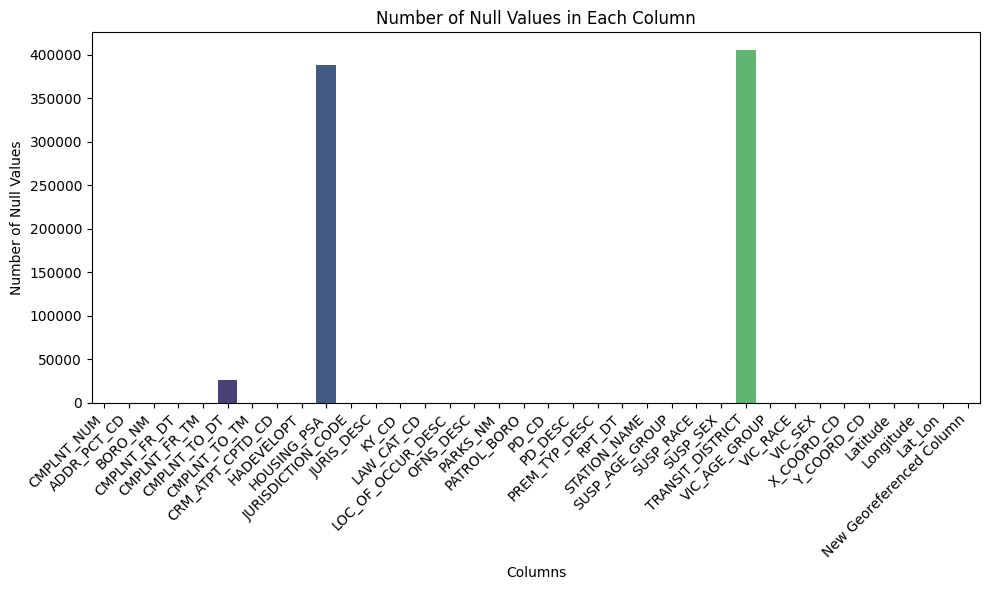

Count of duplicate rows: 415310
415310
Misspelling Detection
CMPLNT_NUM : 304
BORO_NM : 1
No misspellings found in CRM_ATPT_CPTD_CD.
HADEVELOPT : 13
JURIS_DESC : 13
No misspellings found in LAW_CAT_CD.
LOC_OF_OCCUR_DESC : 1
OFNS_DESC : 22
PARKS_NM : 221
PATROL_BORO : 2
PD_DESC : 263
PREM_TYP_DESC : 39
STATION_NAME : 177
SUSP_RACE : 2
SUSP_SEX : 1
VIC_RACE : 2
No misspellings found in VIC_SEX.
Lat_Lon : 141834
New Georeferenced Column : 141834
Column 'ADDR_PCT_CD': 0 outliers
Column 'HOUSING_PSA': 3597 outliers
Column 'JURISDICTION_CODE': 2246 outliers
Column 'KY_CD': 1368 outliers
Column 'PD_CD': 20851 outliers
Column 'TRANSIT_DISTRICT': 0 outliers
Column 'X_COORD_CD': 28862 outliers
Column 'Y_COORD_CD': 4867 outliers


In [ ]:
#Null,Duplicate,Outlier and Misspelling Debugging

null_counts = calculate_null_counts(df)

    # Display the null counts
null_counts.show()
null_counts_pd = null_counts.toPandas()

import seaborn as sns

# Assuming you already have null_counts_pd DataFrame
# If not, you can use null_counts_pd = null_counts.toPandas()

# Plotting the bar graph using Pandas DataFrame with a color palette
plt.figure(figsize=(10, 6))
sns.barplot(data=null_counts_pd, palette="viridis")
plt.title('Number of Null Values in Each Column')
plt.xlabel('Columns')
plt.ylabel('Number of Null Values')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

#show duplicate count
dc=duplicate_data(spark,df)
print(dc)

#show misspellings
print('Misspelling Detection')
check_spelling(spark,df)

# Show the updated DataFrame with the new 'Misspelling' column
#df_spark_checked.show()

# Execute the function
count_outliers(spark, df)


Numerical Columns: ['ADDR_PCT_CD', 'HOUSING_PSA', 'JURISDICTION_CODE', 'KY_CD', 'PD_CD', 'TRANSIT_DISTRICT', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude']
String Columns: ['CMPLNT_NUM', 'BORO_NM', 'CMPLNT_FR_DT', 'CMPLNT_TO_DT', 'CMPLNT_TO_TM', 'CRM_ATPT_CPTD_CD', 'HADEVELOPT', 'JURIS_DESC', 'LAW_CAT_CD', 'LOC_OF_OCCUR_DESC', 'OFNS_DESC', 'PARKS_NM', 'PATROL_BORO', 'PD_DESC', 'PREM_TYP_DESC', 'RPT_DT', 'STATION_NAME', 'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX', 'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX', 'Lat_Lon', 'New Georeferenced Column']
{'latitude': 'Latitude', 'longitude': 'Longitude', 'x_coord': 'X_COORD_CD', 'y_coord': 'Y_COORD_CD'}
Checking column: Latitude, Min: -90, Max: 90
Checking column: Longitude, Min: -180, Max: 180
Checking column: X_COORD_CD, Min: 900000, Max: 1060000
Checking column: Y_COORD_CD, Min: 120000, Max: 280000
Invalid Counts per Column: {'Latitude': 0, 'Longitude': 0, 'X_COORD_CD': 906, 'Y_COORD_CD': 1}
Non-numeric Counts per Numeric Column: {'ADDR_PCT_C

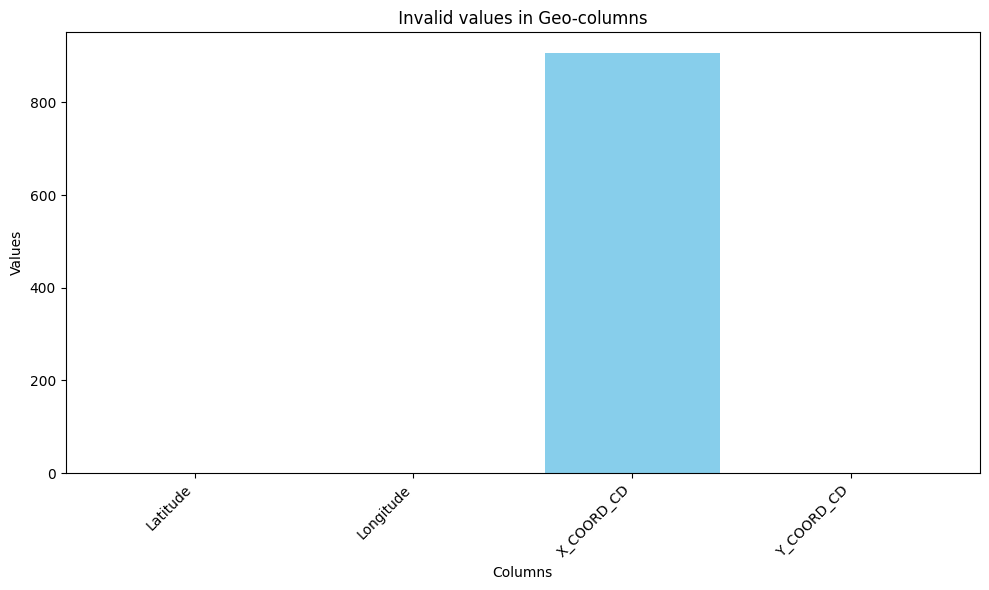

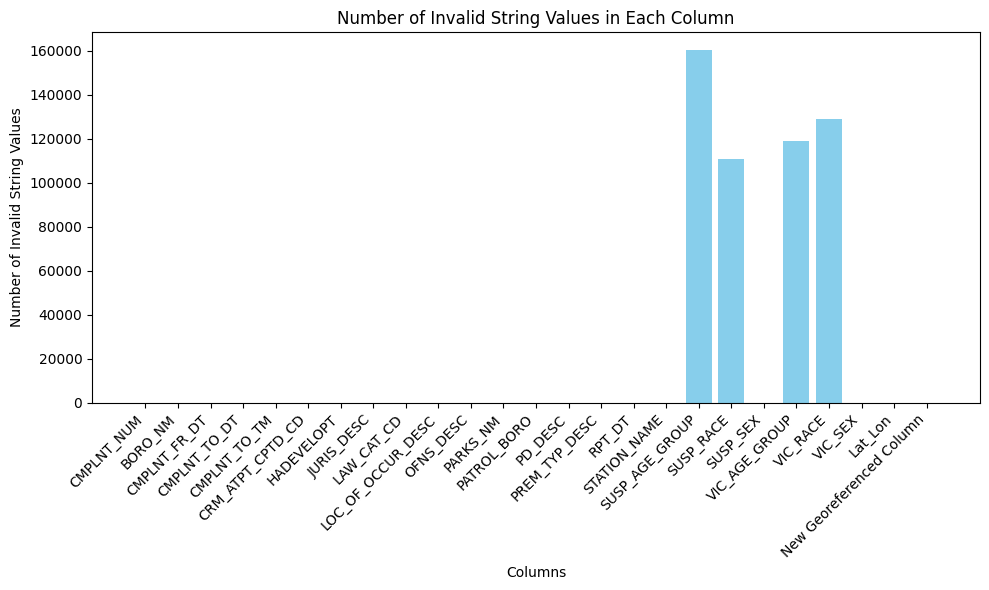

Garbage Counts per Numeric Column: {'ADDR_PCT_CD': 0, 'HOUSING_PSA': 0, 'JURISDICTION_CODE': 0, 'KY_CD': 0, 'PD_CD': 0, 'TRANSIT_DISTRICT': 0, 'X_COORD_CD': 0, 'Y_COORD_CD': 0, 'Latitude': 0, 'Longitude': 0}
Non-numeric Counts per Numeric Column: {'ADDR_PCT_CD': 0, 'HOUSING_PSA': 0, 'JURISDICTION_CODE': 0, 'KY_CD': 0, 'PD_CD': 0, 'TRANSIT_DISTRICT': 0, 'X_COORD_CD': 0, 'Y_COORD_CD': 0, 'Latitude': 0, 'Longitude': 0}
Matched Columns: {'sex': ['SUSP_SEX', 'VIC_SEX'], 'gender': []}
Non-numeric Counts per Numeric Column: {'ADDR_PCT_CD': 0, 'HOUSING_PSA': 0, 'JURISDICTION_CODE': 0, 'KY_CD': 0, 'PD_CD': 0, 'TRANSIT_DISTRICT': 0, 'X_COORD_CD': 0, 'Y_COORD_CD': 0, 'Latitude': 0, 'Longitude': 0}
Matched Columns: {'age_group': 'SUSP_AGE_GROUP'}
Count of invalid values in 'SUSP_AGE_GROUP': 223802
Column: ADDR_PCT_CD, Most Common Pattern: \d\d.\d, Mismatches: 132864
Column: HOUSING_PSA, Most Common Pattern: \D\D\D, Mismatches: 27225
Column: JURISDICTION_CODE, Most Common Pattern: \d, Mismatches: 2

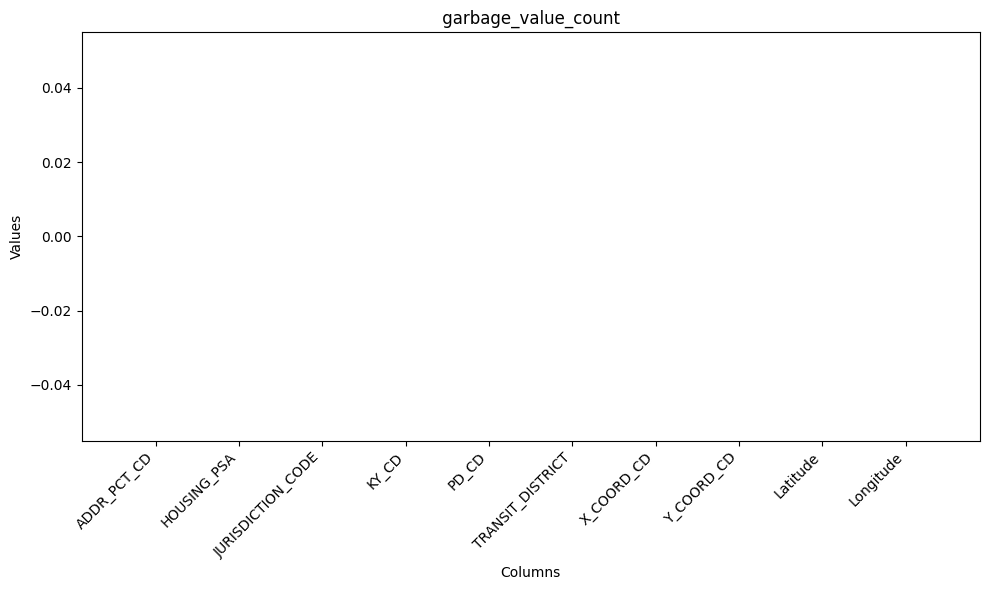

In [ ]:
#FOR DEBUGGING PURPOSE ONLY
numerical_cols, string_cols = segregate_columns(df)
# Print the results for debugging purpose
print("Numerical Columns:", numerical_cols)
print("String Columns:", string_cols)

#to search for geospatial co-ordinates in the dataset
search_keys = ["latitude", "longitude", "x_coord", "y_coord"]
matched_cols = fuzzy_match_columns(df, search_keys)
# Print the results for debugging purpose
print(matched_cols)
# Invalid valyes in geocolumn
invalid_counts= count_invalid_values_per_geocolumn(df, range_constraints, matched_cols)
print("Invalid Counts per Column:", invalid_counts)
plt.figure(figsize=(10, 6))
plt.bar(invalid_counts.keys(), invalid_counts.values(), color='skyblue')
plt.title(' Invalid values in Geo-columns ')
plt.xlabel('Columns')
plt.ylabel('Values')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
#pdf.savefig()
plt.tight_layout()
non_numeric_value_counts = count_non_numeric_in_numeric_columns(df, numerical_cols)
print("Non-numeric Counts per Numeric Column:", non_numeric_value_counts)


###### Invalid geo values column execution finished.

#check for invalid values in string column
invalid_value_counts = count_invalid_string_values(df, string_cols)
print("Invalid String Counts per Column:", invalid_value_counts)
columns = list(invalid_value_counts.keys())
counts = list(invalid_value_counts.values())

# Plot bar graph
plt.figure(figsize=(10, 6))
plt.bar(columns, counts, color='skyblue')
plt.title('Number of Invalid String Values in Each Column')
plt.xlabel('Columns')
plt.ylabel('Number of Invalid String Values')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()


#invlaid values in numeric column
garbage_value_counts = count_garbage_values_numeric(df, numerical_cols)
print("Garbage Counts per Numeric Column:", garbage_value_counts)

plt.figure(figsize=(10, 6))
plt.bar(garbage_value_counts.keys(), garbage_value_counts.values(), color='skyblue')
plt.title(' garbage_value_count ')
plt.xlabel('Columns')
plt.ylabel('Values')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
#pdf.savefig()
plt.tight_layout()
non_numeric_value_counts = count_non_numeric_in_numeric_columns(df, numerical_cols)
print("Non-numeric Counts per Numeric Column:", non_numeric_value_counts)

#sex column validity
search_keys = ["sex","gender"]  # Replace with your search keys
matched_columns = fuzzy_match_columns_all_matches(df, search_keys)
print("Matched Columns:", matched_columns)
invalid_sex_value_counts = count_invalid_sex_values(df, matched_columns)
print("Counts for invalid sex columns:", invalid_sex_value_counts)
non_numeric_value_counts = count_non_numeric_in_numeric_columns(df, numerical_cols)
print("Non-numeric Counts per Numeric Column:", non_numeric_value_counts)



##### end of sex column validity

#age column validity
age_group(df)

# TO BE RAN BY NOT PYSPARK CODE
for column in numerical_cols:
  pattern, mismatches = find_pattern_and_count_mismatches(df_pandas, column)
  print(f"Column: {column}, Most Common Pattern: {pattern}, Mismatches: {mismatches}")



In [ ]:
#TO CEHCK FOR TOP 5 CO - OCCURENCES IN EACH COLUMN

co_occurrence_results = co_occurrence_analysis(df_pandas)

# Print top co-occurrence results
for columns, top_co_occur in co_occurrence_results.items():
    print(f"Top Co-occurrence in Columns: {columns}")
    for pair, count in top_co_occur:
        print(f"  {pair}: {count}")

Top Co-occurrence in Columns: ('CMPLNT_NUM', 'BORO_NM')
  ('270652286', 'BRONX'): 1
  ('269679657H1', 'MANHATTAN'): 1
  ('270825324', 'STATEN ISLAND'): 1
  ('274700214', 'MANHATTAN'): 1
  ('272352661', 'STATEN ISLAND'): 1
Top Co-occurrence in Columns: ('CMPLNT_NUM', 'CMPLNT_FR_DT')
  ('270652286', '07/01/2023'): 1
  ('269679657H1', '06/09/2023'): 1
  ('270825324', '07/02/2023'): 1
  ('274700214', '09/19/2023'): 1
  ('272352661', '08/03/2023'): 1
Top Co-occurrence in Columns: ('CMPLNT_NUM', 'CMPLNT_FR_TM')
  ('270652286', '05:00:00'): 1
  ('269679657H1', '08:13:00'): 1
  ('270825324', '19:30:00'): 1
  ('274700214', '18:05:00'): 1
  ('272352661', '17:20:00'): 1
Top Co-occurrence in Columns: ('CMPLNT_NUM', 'CMPLNT_TO_DT')
  ('270652286', nan): 1
  ('269679657H1', nan): 1
  ('270825324', '07/02/2023'): 1
  ('274700214', '09/19/2023'): 1
  ('272352661', '08/03/2023'): 1
Top Co-occurrence in Columns: ('CMPLNT_NUM', 'CMPLNT_TO_TM')
  ('270652286', '(null)'): 1
  ('269679657H1', '(null)'): 1
 